# Simulate LFP Correlation

This notebook...

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
from scipy.stats import linregress

import neo
from neurodsp.sim.transients import sim_synaptic_kernel
from specparam import SpectralModel
import elephant.conversion as conv
import quantities as pq

import sys
sys.path.append("../../allen_vc")
from analysis import compute_psd
from utils import knee_freq

print("Packages Imported!")

Packages Imported!


## Settings

In [2]:
# paths
PROJECT_PATH = 'D:/visual_encoding'
STIM_CODE = 'natural_movie_one_shuffled'

# spectra
FS = 1250
N_JOBS = -1
F_MIN = 2
F_MAX = 200
BANDWIDTH = 1

#specparam
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [2, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0, # (default: 0) 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2, # (default: 2.0)
    'aperiodic_mode'    :   'knee',
    'verbose'           :   False}

In [3]:
# create output filepaths

if not os.path.exists(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}"):
    os.mkdir(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}")
    os.mkdir(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/empirical_lfp")
    os.mkdir(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted")
    os.mkdir(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/empirical_lfp")
    

## Helper Functions

In [4]:

def linplot(df, x_name, y_name, color_by=None, ax=None):

    pdf = df.dropna(subset=[x_name, y_name])
    
    x = pdf[x_name]
    y = pdf[y_name]

    if color_by is not None:
        
        for subject in pdf[color_by].unique():

            ses_df = pdf[pdf[color_by] == subject]

            x_ses = ses_df[x_name]
            y_ses = ses_df[y_name]

            ax.scatter(x_ses, y_ses, alpha=0.7)
    else:

        ax.scatter(x, y, alpha=0.7)
        
    
    results = linregress(x, y)
    t_lin = np.linspace(min(x), max(x), 100)
    lin = results.slope * t_lin + results.intercept

    ax.plot(t_lin, lin, linewidth=5, color='red')

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.grid(True)

    return results

## Load Data

In [5]:
# load actual params
param_df = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/{STIM_CODE}/lfp_params.csv')

# change knee value to Hz
param_df['knee'] = knee_freq(param_df['knee'], param_df['exponent'])

../../allen_vc\utils.py:194: RuntimeWarning: invalid value encountered in double_scalars
  knee_hz[ii] = knee[ii]**(1/exponent[ii])


In [6]:
# interesting nan values
(param_df['knee']**(1/param_df['exponent'])).isna().sum()

1668

## Main

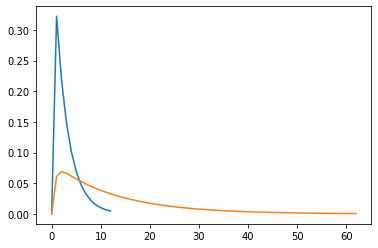

In [7]:
# create synaptic kernels based on Gao 2017

tau_r_E = 1e-4
tau_d_E = 2e-3
t_ker_E = 5*tau_d_E

tau_r_I = 5e-4
tau_d_I = 1e-2
t_ker_I = 5*tau_d_I

ampa = sim_synaptic_kernel(t_ker_E, FS, tau_r_E, tau_d_E)
gaba = sim_synaptic_kernel(t_ker_I, FS, tau_r_I, tau_d_I)

plt.plot(ampa)
plt.plot(gaba);

In [8]:
# load blocks

sim_lfp_data = []

for i_file, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    
    block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    session = file.split('_')[1].split('.')[0]
    
    print(f"Compute Session {session}:")
    
    block_data = []
    sim_lfps = []
    
    # loop through epochs
    for i_seg, seg in enumerate(block.segments):
        
        if i_seg%10 == 0:
            print(f"\t segment ({i_seg + 1}/{len(block.segments)})")
            
        if seg.annotations['running'] is True:
            continue
        
        # filter spikes by cell type, convert to bool array
        inhib = seg.filter(cell_type='inhibitory')
        excit = seg.filter(cell_type='excitatory')
        
        
        if len(inhib) > 0:
            inhib_bool = conv.BinnedSpikeTrain(inhib, binsize=(1/FS)*pq.s).to_bool_array()
            inhib_spikes = np.sum(inhib_bool, axis=0)
            
        else:
            inhib_spikes = np.zeros(30*FS)
            
            
        if len(excit) > 0:
            excit_bool = conv.BinnedSpikeTrain(excit, binsize=(1/FS)*pq.s).to_bool_array()
            excit_spikes = np.sum(excit_bool, axis=0)
            
        else:
            excit_spikes = np.zeros(30*FS)
            
        
        # convolve
        inhib_lfp = np.convolve(inhib_spikes, gaba, 'same') # use same to preserve dimensions with lfp
        excit_lfp = np.convolve(excit_spikes, ampa, 'same')
        
        # summate
        sim_lfp = excit_lfp - inhib_lfp
        
        # compute correlation with actual lfp
        lfp = np.array(seg.filter(name='lfp')[0])[:37500] # compute for each channel
        # lfp[np.isnan(lfp)] = 0
        
        if np.isnan(lfp).sum() > 0:
            print(f"NaNs in seg {i_seg}")
            
        if lfp.shape[0] != sim_lfp.shape[0]:
            print(f"LFP / spike shape mismatch in seg {i_seg}")
            continue
        
        corrs = []
        for i_chan in range(lfp.shape[1]):
            
            corr = np.corrcoef(sim_lfp, lfp[:, i_chan])[0, 1] # nan values in lfp -> nan
            corrs.append(corr)
        
        # compute spectral power
        spectra, freq = compute_psd(sim_lfp, FS, fmin=F_MIN, fmax=F_MAX, bandwidth=BANDWIDTH,
                                    n_jobs=N_JOBS, verbose=False)
        
        # compute specparam metrics
        fm = SpectralModel(**SPEC_PARAM_SETTINGS)
        fm.fit(freq, spectra)
        params = fm.aperiodic_params_
        
        block_data.append([params[0], knee_freq(params[1], params[2]), params[2], fm.r_squared_, corrs, i_seg, range(lfp.shape[1])])
        sim_lfps.append(sim_lfp)
        
    if len(block_data) == 0:
        print(f"No stationary data for session {session}")
        continue
    
    # create dataframe
    df = pd.DataFrame(block_data, columns=['offset', 'knee', 'exponent', 'r_squared', 'sim_corr', 'epoch_idx', 'chan_idx'])
    df['session'] = session
    sim_lfp_data.append(df.explode(['sim_corr', 'chan_idx']))
    
    np.save(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/empirical_lfp/{session}", np.stack(sim_lfps))
    
    
# concatenate
sim_lfp_df = pd.concat(sim_lfp_data)

# save
sim_lfp_df.to_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/params.csv',index=False)

Compute Session 847657808:
	 segment (1/20)
	 segment (11/20)
Compute Session 840012044:
	 segment (1/20)
	 segment (11/20)
Compute Session 839068429:
	 segment (1/20)
	 segment (11/20)
No stationary data for session 839068429
Compute Session 835479236:
	 segment (1/20)
	 segment (11/20)
Compute Session 831882777:
	 segment (1/20)
	 segment (11/20)
No stationary data for session 831882777
Compute Session 829720705:
	 segment (1/20)
	 segment (11/20)
Compute Session 821695405:
	 segment (1/20)
	 segment (11/20)
Compute Session 816200189:
	 segment (1/20)
	 segment (11/20)
Compute Session 794812542:
	 segment (1/20)
	 segment (11/20)
Compute Session 793224716:
	 segment (1/20)
	 segment (11/20)
Compute Session 789848216:
	 segment (1/20)
	 segment (11/20)
Compute Session 787025148:
	 segment (1/20)
	 segment (11/20)
Compute Session 786091066:
	 segment (1/20)
	 segment (11/20)
No stationary data for session 786091066
Compute Session 781842082:
	 segment (1/20)
	 segment (11/20)
Compute S

Now lets weight the convolution product by characteristic voltage potential differences for each cell type.

Reference : [rdgao](https://github.com/rdgao/specparam-sbi/blob/main/demo_notebooks/2-EI.ipynb)

In [9]:
# cell voltage potential values

V_rest = -65
V_rev_E = 0
V_rev_I = -80

In [10]:
# load blocks

sim_lfp_data = []

for i_file, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    
    block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    session = file.split('_')[1].split('.')[0]
    
    print(f"Compute Session {session}:")
    
    block_data = []
    sim_lfps = []
    
    # loop through epochs
    for i_seg, seg in enumerate(block.segments):
        
        if i_seg%10 == 0:
            print(f"\t segment ({i_seg + 1}/{len(block.segments)})")
            
        if seg.annotations['running'] is True:
            continue
        
        # filter spikes by cell type, convert to bool array
        inhib = seg.filter(cell_type='inhibitory')
        excit = seg.filter(cell_type='excitatory')
        
        
        if len(inhib) > 0:
            inhib_bool = conv.BinnedSpikeTrain(inhib, binsize=(1/FS)*pq.s).to_bool_array()
            inhib_spikes = np.sum(inhib_bool, axis=0)
            
        else:
            inhib_spikes = np.zeros(30*FS)
            
            
        if len(excit) > 0:
            excit_bool = conv.BinnedSpikeTrain(excit, binsize=(1/FS)*pq.s).to_bool_array()
            excit_spikes = np.sum(excit_bool, axis=0)
            
        else:
            excit_spikes = np.zeros(30*FS)
            
        
        # convolve
        inhib_lfp = np.convolve(inhib_spikes, gaba, 'same') * (V_rest - V_rev_I)
        excit_lfp = np.convolve(excit_spikes, ampa, 'same') * (V_rest - V_rev_E)
        
        # summate
        sim_lfp = excit_lfp + inhib_lfp
        
        # compute correlation with actual lfp
        lfp = np.array(seg.filter(name='lfp')[0])[:37500] # compute for each channel
        # lfp[np.isnan(lfp)] = 0
        
        if np.isnan(lfp).sum() > 0:
            print(f"NaNs in seg {i_seg}")
            
        if lfp.shape[0] != sim_lfp.shape[0]:
            print(f"LFP / spike shape mismatch in seg {i_seg}")
            continue
        
        corrs = []
        for i_chan in range(lfp.shape[1]):
            
            corr = np.corrcoef(sim_lfp, lfp[:, i_chan])[0, 1] # nan values in lfp -> nan
            corrs.append(corr)
        
        # compute spectral power
        spectra, freq = compute_psd(sim_lfp, FS, fmin=F_MIN, fmax=F_MAX, bandwidth=BANDWIDTH,
                                    n_jobs=N_JOBS, verbose=False)
        
        # compute specparam metrics
        fm = SpectralModel(**SPEC_PARAM_SETTINGS)
        fm.fit(freq, spectra)
        params = fm.aperiodic_params_
        
        block_data.append([params[0], knee_freq(params[1], params[2]), params[2], fm.r_squared_, corrs, i_seg, range(lfp.shape[1])])
        sim_lfps.append(sim_lfp)
        
    if len(block_data) == 0:
        print(f"No stationary data for session {session}")
        continue
        
    # create dataframe
    df = pd.DataFrame(block_data, columns=['offset', 'knee', 'exponent', 'r_squared', 'sim_corr', 'epoch_idx', 'chan_idx'])
    df['session'] = session
    sim_lfp_data.append(df.explode(['sim_corr', 'chan_idx']))
    
    np.save(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/empirical_lfp/{session}", np.stack(sim_lfps))
    
# concatenate
sim_lfp_df = pd.concat(sim_lfp_data)

# save
sim_lfp_df.to_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/params.csv',index=False)

Compute Session 847657808:
	 segment (1/20)
	 segment (11/20)
Compute Session 840012044:
	 segment (1/20)


../../allen_vc\utils.py:189: RuntimeWarning: invalid value encountered in double_scalars
  knee_hz = knee**(1/exponent)


	 segment (11/20)
Compute Session 839068429:
	 segment (1/20)
	 segment (11/20)
No stationary data for session 839068429
Compute Session 835479236:
	 segment (1/20)
	 segment (11/20)
Compute Session 831882777:
	 segment (1/20)
	 segment (11/20)
No stationary data for session 831882777
Compute Session 829720705:
	 segment (1/20)
	 segment (11/20)
Compute Session 821695405:
	 segment (1/20)
	 segment (11/20)
Compute Session 816200189:
	 segment (1/20)
	 segment (11/20)
Compute Session 794812542:
	 segment (1/20)
	 segment (11/20)
Compute Session 793224716:
	 segment (1/20)
	 segment (11/20)
Compute Session 789848216:
	 segment (1/20)
	 segment (11/20)
Compute Session 787025148:
	 segment (1/20)
	 segment (11/20)
Compute Session 786091066:
	 segment (1/20)
	 segment (11/20)
No stationary data for session 786091066
Compute Session 781842082:
	 segment (1/20)
	 segment (11/20)
Compute Session 779839471:
	 segment (1/20)
	 segment (11/20)
Compute Session 778998620:
	 segment (1/20)
	 segment

## Results

Below are results from the original methodology where the convolved current is not weighted, the simulated lfp is calculated as the excitatory minus the inhibitory current, and nans are not handled.

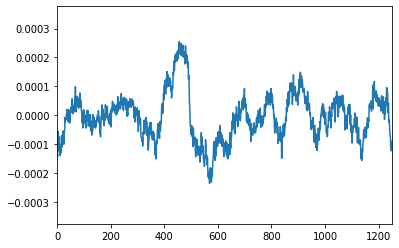

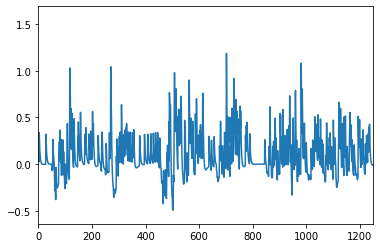

In [11]:
# load example block
session = 816200189
i_seg = 4
lfp_chan = 0

block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/block_{session}.mat").read_block()
seg = block.segments[i_seg]

lfp = np.array(seg.filter(name='lfp')[0])[:37500][:, lfp_chan]
sim_lfp = np.load(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/empirical_lfp/{session}.npy")[i_seg]

# plot raw lfp
plt.plot(lfp)
plt.xlim([0,FS])
plt.show()

# plot sim
plt.plot(sim_lfp)
plt.xlim([0,FS])
plt.show()

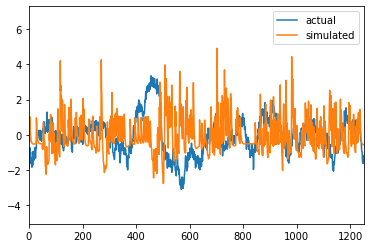

In [12]:
# plot examples with actual LFP side by side

plt.plot(zscore(lfp), label='actual')
plt.plot(zscore(sim_lfp), label='simulated')
plt.xlim([0,FS])
plt.legend();

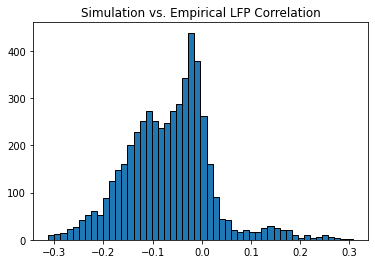

In [13]:
# plot correlation coefficient distribution
sim_lfp_df = pd.read_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/params.csv')

plt.hist(sim_lfp_df['sim_corr'], edgecolor='black', bins=50)
plt.title('Simulation vs. Empirical LFP Correlation');

offset: LinregressResult(slope=-0.01690615534825565, intercept=-4.798085932563043, rvalue=-0.00693190589833702, pvalue=0.6207239400036262, stderr=0.03416386937920178, intercept_stderr=0.07083750254220829)
knee: LinregressResult(slope=-0.026819055386153933, intercept=6.151000060071916, rvalue=-0.10810654387577986, pvalue=5.468796819984926e-12, stderr=0.0038791858574908377, intercept_stderr=0.15123541114593758)
exponent: LinregressResult(slope=-0.06147246650220921, intercept=1.9960594116876227, rvalue=-0.026207831519910463, pvalue=0.06132997386385209, stderr=0.032846238514342756, intercept_stderr=0.047850542447651565)


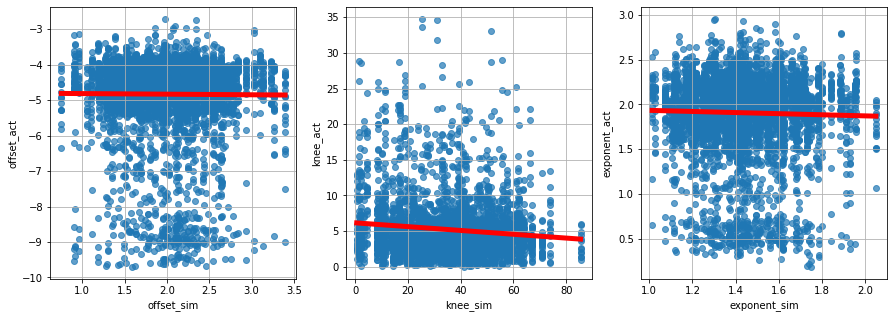

In [14]:
# plot specparams

full_df = sim_lfp_df.merge(param_df, on=['session', 'epoch_idx', 'chan_idx'], suffixes=('_sim', '_act'))

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(full_df, f"{var}_sim", f"{var}_act", ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=-0.01690615534825565, intercept=-4.798085932563043, rvalue=-0.00693190589833702, pvalue=0.6207239400036262, stderr=0.03416386937920178, intercept_stderr=0.07083750254220829)
knee: LinregressResult(slope=-0.026819055386153933, intercept=6.151000060071916, rvalue=-0.10810654387577986, pvalue=5.468796819984926e-12, stderr=0.0038791858574908377, intercept_stderr=0.15123541114593758)
exponent: LinregressResult(slope=-0.06147246650220921, intercept=1.9960594116876227, rvalue=-0.026207831519910463, pvalue=0.06132997386385209, stderr=0.032846238514342756, intercept_stderr=0.047850542447651565)


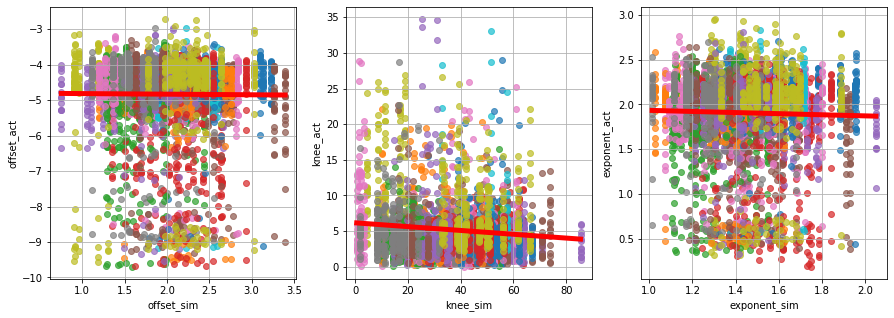

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(full_df, f"{var}_sim", f"{var}_act", color_by="session" ,ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=-0.014885625031195332, intercept=-4.791956876167714, rvalue=-0.02534081673996116, pvalue=0.711135978484106, stderr=0.04014210038466485, intercept_stderr=0.08315766345341978)
knee: LinregressResult(slope=-0.02277721040025286, intercept=5.831621122969434, rvalue=-0.20219235394099347, pvalue=0.0028333694881473616, stderr=0.007541626086680706, intercept_stderr=0.2971572987874685)
exponent: LinregressResult(slope=-0.06170590731231039, intercept=2.0010603482576435, rvalue=-0.07033074803682025, pvalue=0.30351556238460753, stderr=0.05982708649819151, intercept_stderr=0.08728938723801566)


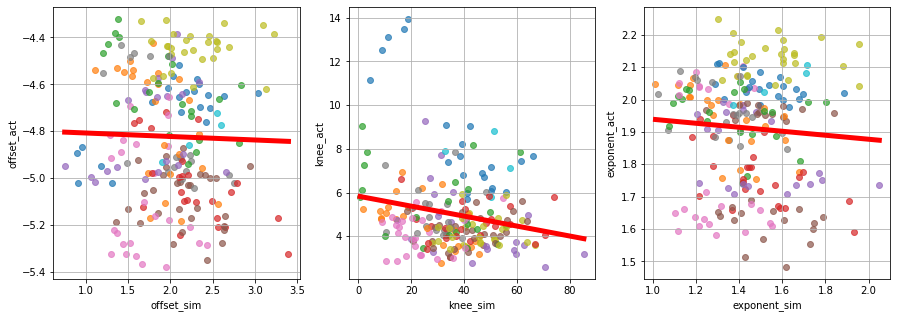

In [16]:
# plot summary graphic (average across channels)

chan_avg_df = full_df.groupby(['session', 'epoch_idx']).mean().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(chan_avg_df, f"{var}_sim", f"{var}_act", color_by="session", ax=axs[i])
    print(f"{var}: {res}")

In [17]:
# join with spike stats df

spike_df = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/{STIM_CODE}.csv')
vis_spike_df = spike_df[spike_df['brain_structure'] == 'VISp']
spike_lfp_df = chan_avg_df.merge(vis_spike_df, on=['session', 'epoch_idx'])

('mean_firing_rate', 'r_squared_sim'): LinregressResult(slope=0.000872059790644408, intercept=0.933032217116288, rvalue=0.13830566729126884, pvalue=0.04229105961944519, stderr=0.0004268796645314851, intercept_stderr=0.002682749988288894)


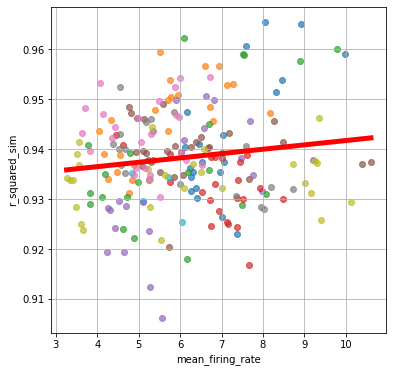

In [18]:
# quality analysis

fig, axs = plt.subplots(1, 1, figsize=(6,6))

for i, var in enumerate([('mean_firing_rate', 'r_squared_sim')]):
    
    res = linplot(spike_lfp_df, var[0], var[1], color_by="session", ax=axs)
    print(f"{var}: {res}")

('mean_firing_rate', 'offset_sim'): LinregressResult(slope=0.016935338699756153, intercept=1.9137523890293913, rvalue=0.055674611622594156, pvalue=0.41557039379366845, stderr=0.02076135408949158, intercept_stderr=0.13047593284064035)
('spike_distance', 'exponent_sim'): LinregressResult(slope=1.947270389016859, intercept=1.1586269662577462, rvalue=0.19355130352895794, pvalue=0.004301590585150207, stderr=0.674733371647846, intercept_stderr=0.10035860110504219)


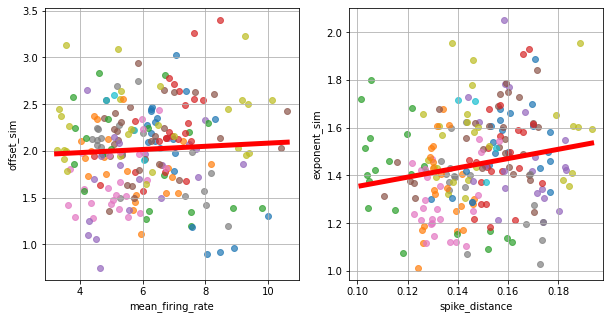

In [19]:
# hypothesis plots

fig, axs = plt.subplots(1, 2, figsize=(10,5))

for i, var in enumerate([('mean_firing_rate', 'offset_sim'), ('spike_distance', 'exponent_sim')]):
    
    res = linplot(spike_lfp_df, var[0], var[1], color_by="session", ax=axs[i])
    print(f"{var}: {res}")

Now we show results where each current is weighted by (V_rest - V_rev), the lfp is calculated as the sum of these weighted currents, and nans are not handled.

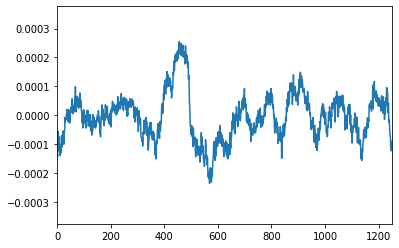

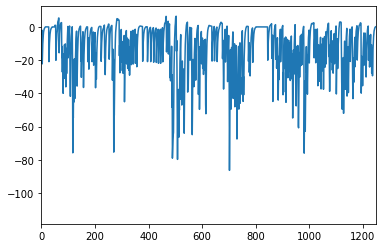

In [20]:
# load example block
session = 816200189
i_seg = 4
lfp_chan = 0

block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/block_{session}.mat").read_block()
seg = block.segments[i_seg]

lfp = np.array(seg.filter(name='lfp')[0])[:37500][:, lfp_chan]
sim_lfp = np.load(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/empirical_lfp/{session}.npy")[i_seg]

# plot raw lfp
plt.plot(lfp)
plt.xlim([0,FS])
plt.show()

# plot sim
plt.plot(sim_lfp)
plt.xlim([0,FS])
plt.show()

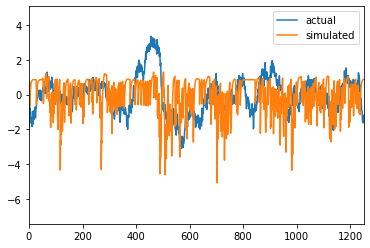

In [21]:
# plot examples with actual LFP side by side

plt.plot(zscore(lfp), label='actual')
plt.plot(zscore(sim_lfp), label='simulated')
plt.xlim([0,FS])
plt.legend();

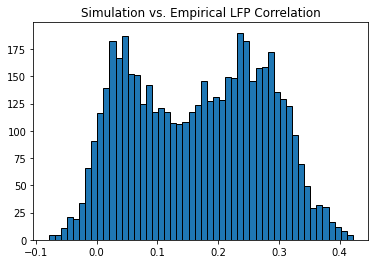

In [22]:
# plot correlation coefficient distribution
sim_lfp_df = pd.read_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/params.csv')

plt.hist(sim_lfp_df['sim_corr'], edgecolor='black', bins=50)
plt.title('Simulation vs. Empirical LFP Correlation');

offset: LinregressResult(slope=0.016915251021499298, intercept=-4.923351255341467, rvalue=0.00881005709939976, pvalue=0.5294155120724876, stderr=0.026894790105123367, intercept_stderr=0.1458049125827643)
knee: LinregressResult(slope=0.005955842230170293, intercept=5.004480946571904, rvalue=0.029452621851096743, pvalue=0.06157927603469121, stderr=0.003185223864777406, intercept_stderr=0.12548853593997464)
exponent: LinregressResult(slope=-0.06310444635399635, intercept=1.9911156011490103, rvalue=-0.03752109942571318, pvalue=0.007377549906560722, stderr=0.023543106832283736, intercept_stderr=0.03191282499565758)


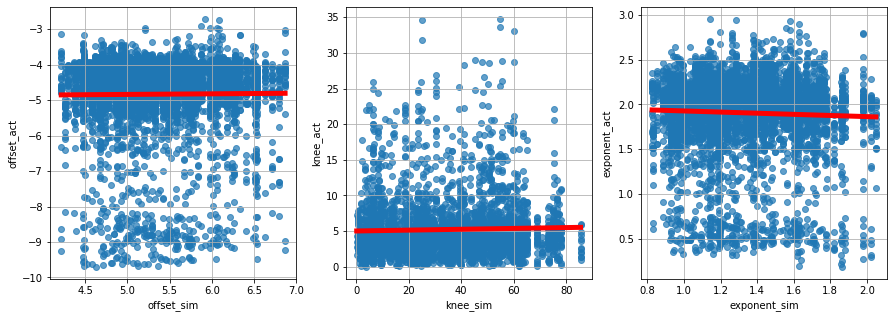

In [23]:
# plot specparams

full_df = sim_lfp_df.merge(param_df, on=['session', 'epoch_idx', 'chan_idx'], suffixes=('_sim', '_act'))

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(full_df, f"{var}_sim", f"{var}_act", ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=0.016915251021499298, intercept=-4.923351255341467, rvalue=0.00881005709939976, pvalue=0.5294155120724876, stderr=0.026894790105123367, intercept_stderr=0.1458049125827643)
knee: LinregressResult(slope=0.005955842230170293, intercept=5.004480946571904, rvalue=0.029452621851096743, pvalue=0.06157927603469121, stderr=0.003185223864777406, intercept_stderr=0.12548853593997464)
exponent: LinregressResult(slope=-0.06310444635399635, intercept=1.9911156011490103, rvalue=-0.03752109942571318, pvalue=0.007377549906560722, stderr=0.023543106832283736, intercept_stderr=0.03191282499565758)


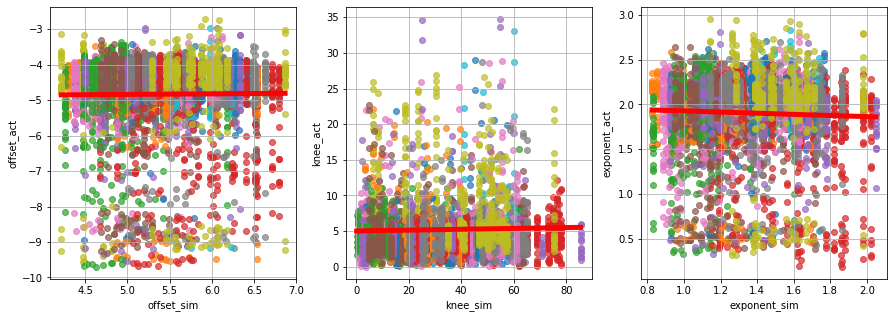

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(full_df, f"{var}_sim", f"{var}_act", color_by="session" ,ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=0.024703781130845353, intercept=-4.95498978715353, rvalue=0.052693824604923764, pvalue=0.44101539971338066, stderr=0.03200317339633987, intercept_stderr=0.17335241048011304)
knee: LinregressResult(slope=0.0060269799776385465, intercept=4.817745186279295, rvalue=0.06611170104926248, pvalue=0.3346486606982897, stderr=0.006232760474978612, intercept_stderr=0.24276048997311248)
exponent: LinregressResult(slope=-0.05751108010554655, intercept=1.9883007998979272, rvalue=-0.09007377575404694, pvalue=0.18723274375028318, stderr=0.04346876545298928, intercept_stderr=0.05896318974554421)


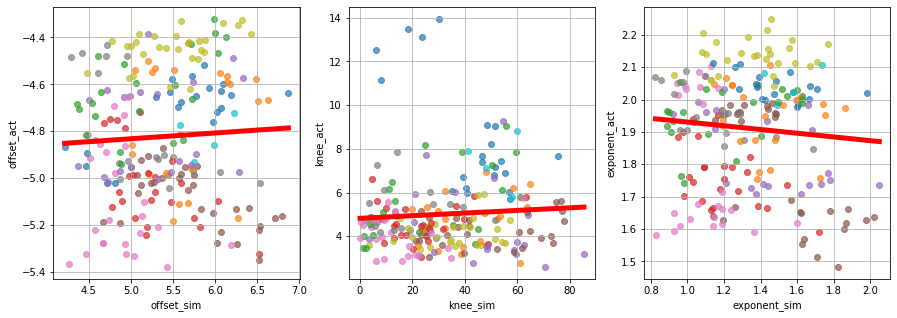

In [25]:
# plot summary graphic (average across channels)

chan_avg_df = full_df.groupby(['session', 'epoch_idx']).mean().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(chan_avg_df, f"{var}_sim", f"{var}_act", color_by="session", ax=axs[i])
    print(f"{var}: {res}")

Let's take a look at correlations between spiking statistics and our simulated LFP.

In [26]:
# join with spike stats df

spike_df = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/{STIM_CODE}.csv')
vis_spike_df = spike_df[spike_df['brain_structure'] == 'VISp']
spike_lfp_df = chan_avg_df.merge(vis_spike_df, on=['session', 'epoch_idx'])

('mean_firing_rate', 'r_squared_sim'): LinregressResult(slope=2.95065936125238e-05, intercept=0.93227003377769, rvalue=0.0051660547487779995, pvalue=0.93982872402813, stderr=0.0003904337830977674, intercept_stderr=0.0024537037344768368)


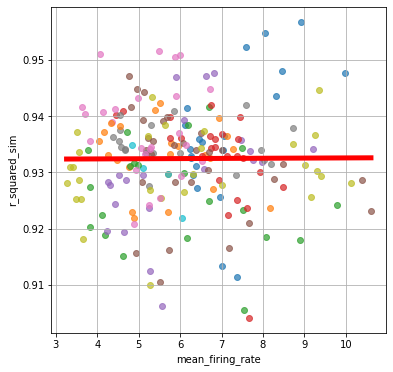

In [27]:
# quality analysis

fig, axs = plt.subplots(1, 1, figsize=(6,6))

for i, var in enumerate([('mean_firing_rate', 'r_squared_sim')]):
    
    res = linplot(spike_lfp_df, var[0], var[1], color_by="session", ax=axs)
    print(f"{var}: {res}")

('mean_firing_rate', 'offset_sim'): LinregressResult(slope=0.09061691977902042, intercept=4.83243020405162, rvalue=0.23775510335355013, pvalue=0.0004240049306631745, stderr=0.02530679731562479, intercept_stderr=0.15904203419161556)
('spike_distance', 'exponent_sim'): LinregressResult(slope=3.397955873459435, intercept=0.8283103434028066, rvalue=0.2457871792918759, pvalue=0.0002648343564414676, stderr=0.9160527997210202, intercept_stderr=0.1362520091363447)


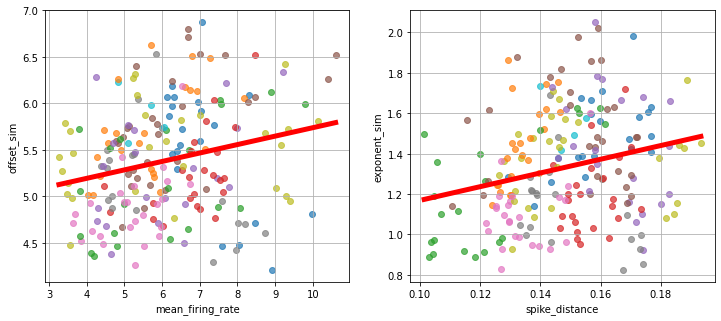

In [28]:
# plot sim offset vs. firing rate

fig, axs = plt.subplots(1, 2, figsize=(12,5))

for i, var in enumerate([('mean_firing_rate', 'offset_sim'), ('spike_distance', 'exponent_sim')]):
    
    res = linplot(spike_lfp_df, var[0], var[1], color_by="session", ax=axs[i])
    print(f"{var}: {res}")